# Analysis of timelapse data from Raspiscope

## Preliminaries
Before processing the images we need to set up the tools and load the data.

### Modules
Import the standard tools, numpy and matplotlib:

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

We will use scikit-image to analyse and process images:

In [2]:
import skimage 
from skimage import io, filters

### Loading images
First we specify a text string with the location and name of image files in the timelapse. We put a %d to represent the frame number, %04d means put the number with 4 digits. Using the % operator on the string we can then form any file name in the series:

In [52]:
#fname = "/Users/timrudge/RaspiScope/Timelapse060117/image_%04d.jpg"
#fname = "/Users/timrudge/RaspiScope/timelapse/timlap_3_%04d.jpg"
fname =  "/Users/timrudge/RaspiScope/Lab_19_1_17/image_%04d.jpg"
fname%(0)

'/Users/timrudge/RaspiScope/Lab_19_1_17/image_0000.jpg'

Lets see what frame 500 looks like. We use PyPlot to read the file into a numpy array. Then PyPlot again to display the array.

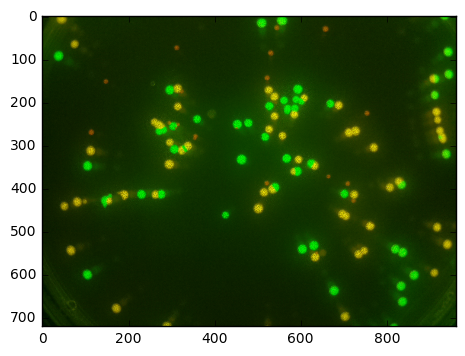

In [53]:
im = plt.imread(fname%500)
plt.imshow(im)

### Loading the time series
We will load all images into a 3-dimensional array, with dimensions x, y, time. First get the size of the image from the numpy array shape, the 3rd dimension is R,G,B.

In [54]:
im.shape
w,h,_ = im.shape

Now we create a numpy array to hold the data and loop over the files, taking only channel 1 (green):

In [55]:
nt = 552
ims = np.zeros((w,h,nt))
for i in range(nt):
    im = plt.imread(fname%i)
    ims[:,:,i] = im[:,:,1]

Now we have a stack (x,y,t):

In [56]:
ims.shape

(720, 960, 552)

## Analysis of time-lapse images
Now we have all the data loaded into a numpy array. To speed things up, take a subregion of the image to analyse. We do this by 'slicing' the array:

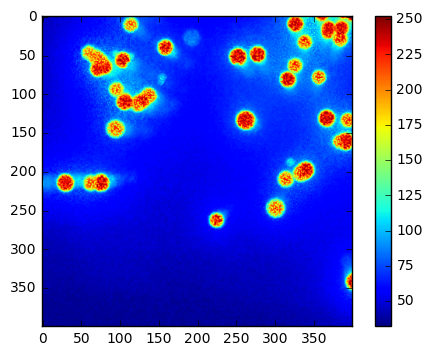

In [226]:
imssub = ims[200:600,200:600,:]
plt.imshow(imssub[:,:,-1])
plt.colorbar()

### Mean dynamics over image domain
We can get some information by looking just at the variation in total image intensity in the time-series. Do this by taking the sum of the (x,y,t) stack over the first two dimensions (0,1):

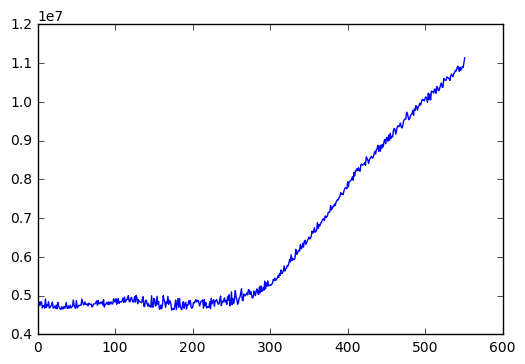

In [228]:
sumims = imssub.sum(axis=(0,1))
plt.plot(sumims)

### Identifying colonies
The colonies vary in brightness over the experiment but remain stationary. So we can take the sum of intensity of each pixel over time, and use it to locate colonies reliably:

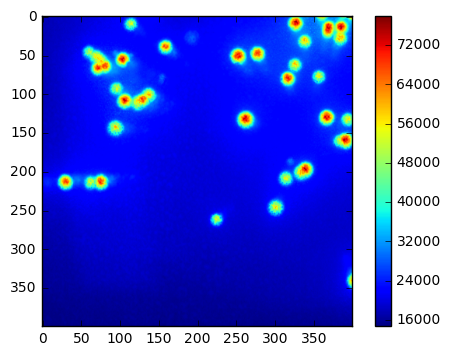

In [59]:
ims_sum = imssub.sum(axis=2)
plt.imshow(ims_sum)
plt.colorbar()

With any image its essential to remove noise before analysis, here with a Gaussian filter. Normalisation to (0,1) is also convenient:

In [60]:
from skimage.filters import gaussian
simsub = gaussian(ims_sum, 2)
nsimsub = (simsub-simsub.min())/(simsub.max()-simsub.min())

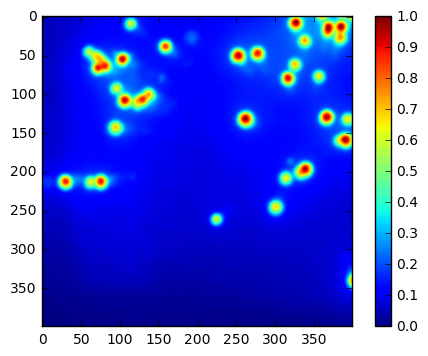

In [61]:
plt.imshow(nsimsub)
plt.colorbar()

Scikit-image provides several functions to detect Gaussian-like features (blobs). We apply this to the smoothed sum of intensity, and it returns a list of position (x,y) and width (standard deviation):

In [62]:
import skimage.feature as skfeat
A = skfeat.blob_log(nsimsub, min_sigma=1.0, max_sigma=10.0, num_sigma=100, threshold=0.25, overlap=0.8)

In [230]:
A.shape
A[1:4,:]

array([[  15.        ,  385.        ,    4.54545455],
       [  17.        ,  367.        ,    5.09090909],
       [  33.        ,  338.        ,    5.27272727]])

The array A now contains the location of probable colonies. We can check by showing the image and plotting markers on top at each location contained in A:

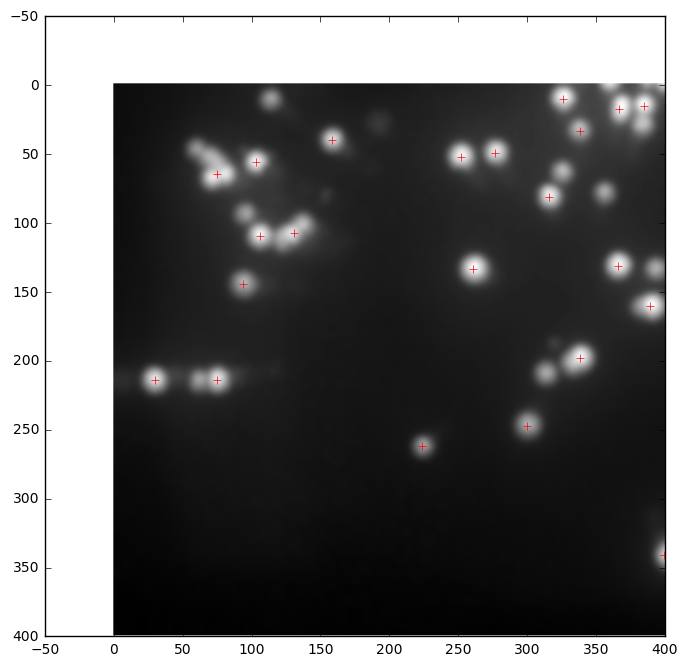

In [232]:
plt.figure(figsize=(8,8))
plt.imshow(nsimsub, cmap='gray')
plt.hold(True)
for i in range(len(A)):
    plt.plot(A[i,1],A[i,0],'r+')

### Time dynamics of colonies
Now we have estimated colony location (and size) we can analyse the dynamics of fluorescence and growth. First to distinguish cell fluorescence from media and background light, we select an empty region of the plate (by eye) and take the mean value in each frame as the background:

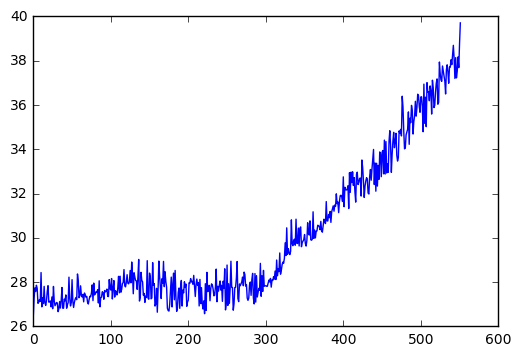

In [181]:
bg = imssub[300:400,0:100,:].mean(axis=(0,1))
plt.plot(bg)

To restrict image analysis for each colony, we can extract a region at each location, with size given by the Gaussian width (x2 = 2 standard deviations). Here we put the image series into a dict indexed by colony. We also subtract the background estimate from each time series.

In [175]:
rois = {}
for i in range(len(A)):
    x = A[i,0]
    y = A[i,1]
    r = 2*A[i,2]
    rois[i] = imssub[x-r:x+r,y-r:y+r,:]-bg

/Users/timrudge/miniconda/envs/raspiscope/lib/python2.7/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Now we can plot the total fluoresence in the region of each colony:

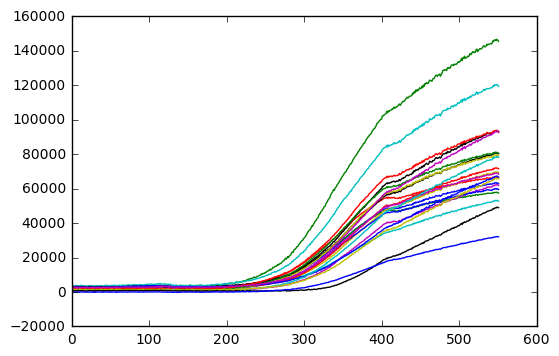

In [219]:
for i in range(len(A)):
    plt.plot(rois[i].sum(axis=(0,1)))
    plt.hold(True)

#### Colony radius growth
We have the location and some kind of size estimate based on the total fluorescence of each colony over the time-lapse. We would like to know the size of the colony in each frame; from this we can compute the growth rate.

One way to do this is the find Gaussian blobs in each of the image regions of the colony, for each frame of the time-lapse. This is very slow, probably there is a simpler way since we can assume a single Gaussian in each image region. Anyway for now it works ok.

The following loop finds blobs and stores the width in each frame. The result is a dict containing the size at each time point for every colony.

In [177]:
R = {}
for k in range(len(A)):
    R[k] = np.zeros((nt,))
    for i in range(nt):
        troi = rois[k][:,:,i].astype(np.float32)
        ntroi = (troi-troi.min())/(troi.max()-troi.min())
        AA = skfeat.blob_log(ntroi, min_sigma=1.0, max_sigma=10.0, num_sigma=200, threshold=0.25, overlap=0.8)
        if len(AA)>0:
            R[k][i] = AA[0,2]

"\nprint AA\nplt.imshow(roi200, interpolation='none')\nplt.figure()\nplt.plot(roi200[7,:])\n"

Since the colony is roughly circular and flat, an estimate of volume is $R^2$. Lets plot this for some colonies. Plotting the log is useful because the slope is the relative growth rate. We can see the colonies slow their growth during the experiment.

/Users/timrudge/miniconda/envs/raspiscope/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log


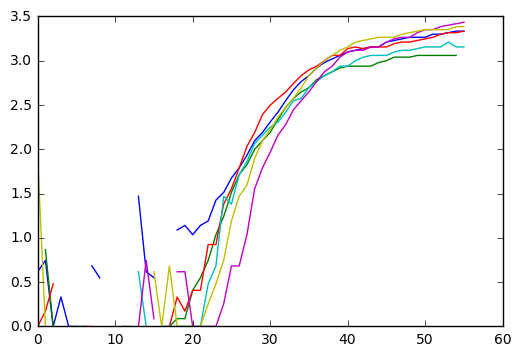

In [220]:
idx = [0,1,2,3,4,9]
for i in idx:
    r = R[i][0:-1:10]
    plt.plot(np.log(r*r))
    plt.hold(True)

#### Check the radius estimate
To see how well the colony size is estimated, we can compare to the profile of a colony in a slice of its image region. The radius (red line) should give the border of the colony.

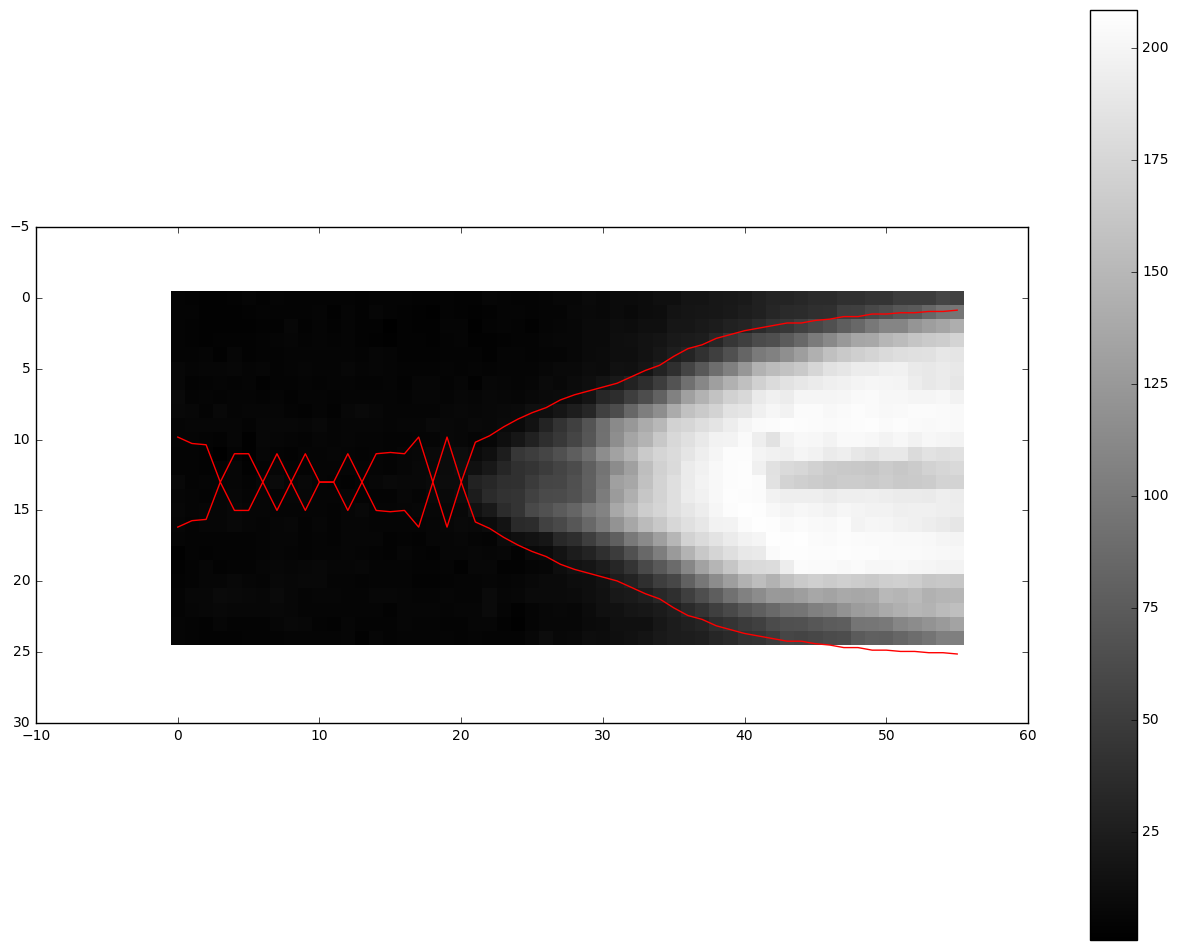

In [237]:
idx = 6
plt.figure(figsize=(16,12))
w,h,d = rois[idx].shape
plt.imshow(rois[idx][w/2+1,:,0:-1:10], interpolation='none', cmap='gray')
plt.colorbar()
plt.hold(True)
plt.plot(-R[idx][0:-1:10]*2+h/2+1,'r')
plt.plot(R[idx][0:-1:10]*2+h/2+1,'r')

### Dynamics plotting
A simple way to view dynamics is a movie, plotting each frame successively. To do this we have to turn off inline plotting so that a new window will open.

In [239]:
%matplotlib auto
mx = np.map(rois[9])
for i in range(300,400):
    plt.imshow(rois[9][:,:,i], interpolation='none', vmin=0, vmax=mx)
    plt.title('%f'%R[9][i])
    plt.pause(0.1)
%matplotlib inline

Using matplotlib backend: MacOSX


AttributeError: 'module' object has no attribute 'map'

### Parameter estimation from data
We should be able to follow the same process as in the ratiometric paper using platereader data. Here testing...

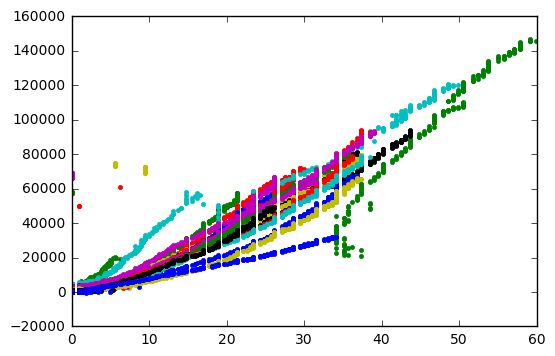

In [222]:
for i in range(len(A)):
    plt.plot(R[i]*R[i], rois[i].sum(axis=(0,1)), '.')
    plt.hold(True)

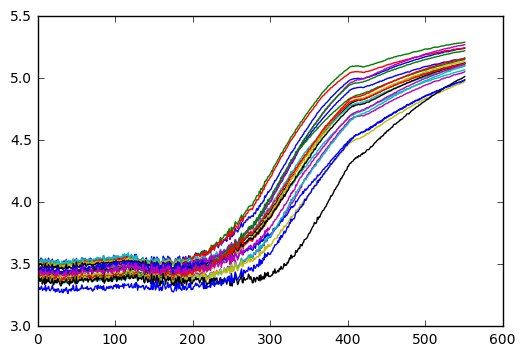

In [135]:
for i in range(len(A)):
    roi = rois[i]
    plt.plot(np.log(roi.mean(axis=(0,1))))
    plt.hold(True)
plt.legend()

In [ ]:
plt.plot(ims[500,200,:])

In [ ]:
plt.figure(figsize=(16,12))
plt.imshow(ims[A[10,0],400:450,:])

In [ ]:
s = np.diff(ims[A[10,0],:,:], axis=1)
s.shape

In [ ]:
c=np.cov(s)
x = A[10,0]
y = A[10,1]
plt.plot(c[y,y-20:y+20])
c[y,y]